<a href="https://colab.research.google.com/github/mgalusza/Notebooks/blob/master/graphSAGE_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [102]:
cd /content/gdrive/My Drive/ML


/content/gdrive/My Drive/ML


In [103]:
cd cora

/content/gdrive/My Drive/ML/cora


In [104]:
!pip install stellargraph

In [0]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

In [0]:
data_dir = os.path.expanduser("")
g_pd = pd.read_csv("Dam_Edge_List.csv",delimiter = ",")
print(g_pd)

     source  target  weight
0         0       1     1.0
1         1     301     1.0
2         2       3     1.0
3         3     264     1.0
4         4       5     1.0
..      ...     ...     ...
424     509     510     1.0
425     510     507     1.0
426     511     411     1.0
427     512       0     1.0
428     512       4     1.0

[429 rows x 3 columns]


In [178]:
#g_nx = nx.from_pandas_edgelist(g_pd,source='source', target='target',edge_attr='weight')

g_nx = nx.read_edgelist(path="Dam_Edge_List.csv",delimiter = ",", nodetype=int, data=(('weight',float),),create_using=nx.DiGraph)

# load the node attribute data
#cora_data_location = os.path.expanduser(os.path.join(data_dir, "Dam_Node_Word.csv"))
#node_attr = pd.read_csv(cora_data_location, sep=',', header=0)
#values = { (row.tolist()[0]): row.tolist()[-1] for _, row in node_attr.iterrows()}
#nx.set_node_attributes(g_nx, values, 'lemma')

# Select the largest connected component. For clarity we ignore isolated
# nodes and subgraphs; having these in the data does not prevent the
# algorithm from running and producing valid results.
#g_nx_ccs = (g_nx.subgraph(c).copy() for c in nx.connected_components(g_nx))
#g_nx = max(g_nx_ccs, key=len)
print("Graph statistics: {} nodes, {} edges".format(
    g_nx.number_of_nodes(), g_nx.number_of_edges()))

Graph statistics: 283 nodes, 429 edges


In [132]:
from zipfile import ZipFile
import re

from sklearn.model_selection import train_test_split
 
import spacy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


!python -m spacy download en_core_web_lg
!python -m spacy link --force en_core_web_lg en

nlp = spacy.load('en')

stops = stopwords.words("english")



def normalize(comment, lowercase=True, remove_stopwords=True):
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if (not remove_stopwords or (remove_stopwords and lemma not in stops and word.pos_ not in 'PUNCT')):
                lemmatized.append(lemma)
    return " ".join(lemmatized)

def transform(word):
    return nlp(word).vector

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_lg -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [0]:
nlp('car').vector.shape

(300,)

In [0]:
column_names = ["node_id","lemma","type"]
node_data = pd.read_table(os.path.join(data_dir, "Dam_Node_Word.csv"), delimiter = ",", header=0, names=column_names)
node_data['vector'] = node_data['lemma'].apply(transform)
node_data = node_data[node_data.index.isin(list(g_nx.nodes()))]

In [0]:
nx.set_node_attributes(g_nx, node_data['node_id'], 'node_id')
nx.set_node_attributes(g_nx, node_data['type'], 'type')
nx.set_node_attributes(g_nx, node_data['lemma'], 'lemma')
nx.set_node_attributes(g_nx, node_data['vector'], 'vector')

In [177]:
g_nx.node[412]

{'lemma': 'none'}

In [173]:
train_data, test_data = model_selection.train_test_split(node_data, train_size=0.1, test_size=None, stratify=node_data['type'], random_state=42)

from collections import Counter
Counter(train_data['type'])

Counter({'none': 3, 'risk': 1, 'susc': 1})

In [0]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)

train_targets = target_encoding.fit_transform(train_data[["type"]].to_dict('records'))
test_targets = target_encoding.transform(test_data[["type"]].to_dict('records'))

In [175]:
G = sg.StellarDiGraph(g_nx, node_features="vector")

In [152]:
print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 283, Edges: 429

 Node types:
  default: [283]
        Attributes: {'type', 'node_id', 'lemma', 'vector'}
    Edge types: default-default->default

 Edge types:
    default-default->default: [429]
        Attributes: {'weight'}



In [0]:
batch_size = 50; num_samples = [10, 10]

In [0]:
generator = GraphSAGENodeGenerator(G, batch_size, num_samples)

In [0]:
train_gen = generator.flow(train_data.index, train_targets)

In [0]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32],
    generator=train_gen,
    bias=True,
    dropout=0.5,
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
x_inp, x_out = graphsage_model.default_model(flatten_output=True)
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [157]:
prediction.shape

TensorShape([Dimension(None), Dimension(3)])

In [0]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [0]:
test_gen = generator.flow(test_data.index, test_targets)

In [163]:
history = model.fit_generator(
    train_gen,
    epochs=50,
    validation_data=test_gen,
    verbose=2,
    shuffle=True,
)

Epoch 1/50
1/1 - 0s - loss: 0.3939 - acc: 1.0000 - val_loss: 0.8382 - val_acc: 0.6875
Epoch 2/50
1/1 - 0s - loss: 0.3855 - acc: 1.0000 - val_loss: 0.8356 - val_acc: 0.6667
Epoch 3/50
1/1 - 0s - loss: 0.3620 - acc: 1.0000 - val_loss: 0.8385 - val_acc: 0.6875
Epoch 4/50
1/1 - 0s - loss: 0.3777 - acc: 1.0000 - val_loss: 0.8372 - val_acc: 0.6875
Epoch 5/50
1/1 - 0s - loss: 0.3622 - acc: 1.0000 - val_loss: 0.8423 - val_acc: 0.6667
Epoch 6/50
1/1 - 0s - loss: 0.3247 - acc: 1.0000 - val_loss: 0.8449 - val_acc: 0.6667
Epoch 7/50
1/1 - 0s - loss: 0.3299 - acc: 1.0000 - val_loss: 0.8516 - val_acc: 0.6667
Epoch 8/50
1/1 - 0s - loss: 0.3395 - acc: 1.0000 - val_loss: 0.8592 - val_acc: 0.6667
Epoch 9/50
1/1 - 0s - loss: 0.3006 - acc: 1.0000 - val_loss: 0.8607 - val_acc: 0.6667
Epoch 10/50
1/1 - 0s - loss: 0.3065 - acc: 1.0000 - val_loss: 0.8544 - val_acc: 0.6667
Epoch 11/50
1/1 - 0s - loss: 0.3036 - acc: 1.0000 - val_loss: 0.8625 - val_acc: 0.6458
Epoch 12/50
1/1 - 0s - loss: 0.2863 - acc: 1.0000 - 

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    metrics = sorted(history.history.keys())
    metrics = metrics[:len(metrics)//2]
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()

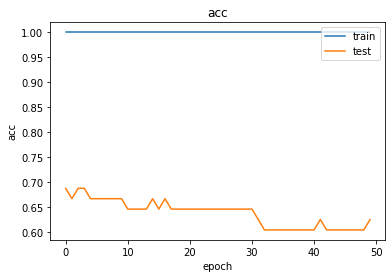

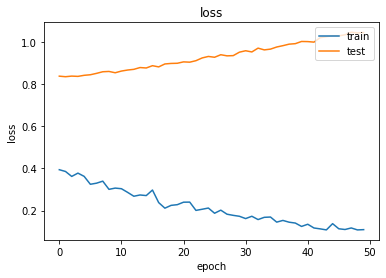

In [165]:
plot_history(history)

In [166]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 1.0503
	acc: 0.6042


In [167]:
all_nodes = node_data.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict_generator(all_mapper)

KeyError: ignored

In [0]:
node_predictions = target_encoding.inverse_transform(all_predictions)

In [0]:
results = pd.DataFrame(node_predictions, index=all_nodes).idxmax(axis=1)
df = pd.DataFrame({"Predicted": results, "True": node_data['subject']})
df.head(10)

,Predicted,True
31336,subject=Theory,Neural_Networks
1061127,subject=Rule_Learning,Rule_Learning
1106406,subject=Reinforcement_Learning,Reinforcement_Learning
13195,subject=Reinforcement_Learning,Reinforcement_Learning
37879,subject=Probabilistic_Methods,Probabilistic_Methods
1126012,subject=Probabilistic_Methods,Probabilistic_Methods
1107140,subject=Theory,Theory
1102850,subject=Theory,Neural_Networks
31349,subject=Theory,Neural_Networks
1106418,subject=Theory,Theory
